# **Import thư viện**

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

# Other imports

import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tempfile import TemporaryDirectory

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
import torchvision
from torchvision import datasets, models, transforms

!pip install wandb
!wandb login d77624ba279c6354e2d27130c47fa3faf424ea9d
import wandb


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **Link Folder**

In [7]:
# Location of data
train_dir = '/kaggle/input/wb-recognition-dataset/wb_recognition_dataset/train'
val_dir = '/kaggle/input/wb-recognition-dataset/wb_recognition_dataset/val'

# **Phân tích số lượng ảnh trong các class của train và val**

Tập train:
Class có nhiều ảnh nhất: 1677, số lượng ảnh: 285
Class có ít ảnh nhất: 954, số lượng ảnh: 1
Giá trị trung bình: 26.672769953051642
Độ lệch chuẩn: 17.114539856127728
Data tập trung chủ yếu trong khoảng từ 9 đến 43 ảnh.

Tập validation:
Class có nhiều ảnh nhất: 1677, số lượng ảnh: 32
Class có ít ảnh nhất: 1739, số lượng ảnh: 1
Giá trị trung bình: 2.339495798319328
Độ lệch chuẩn: 2.8169420957823665
Data tập trung chủ yếu trong khoảng từ 0 đến 5 ảnh.


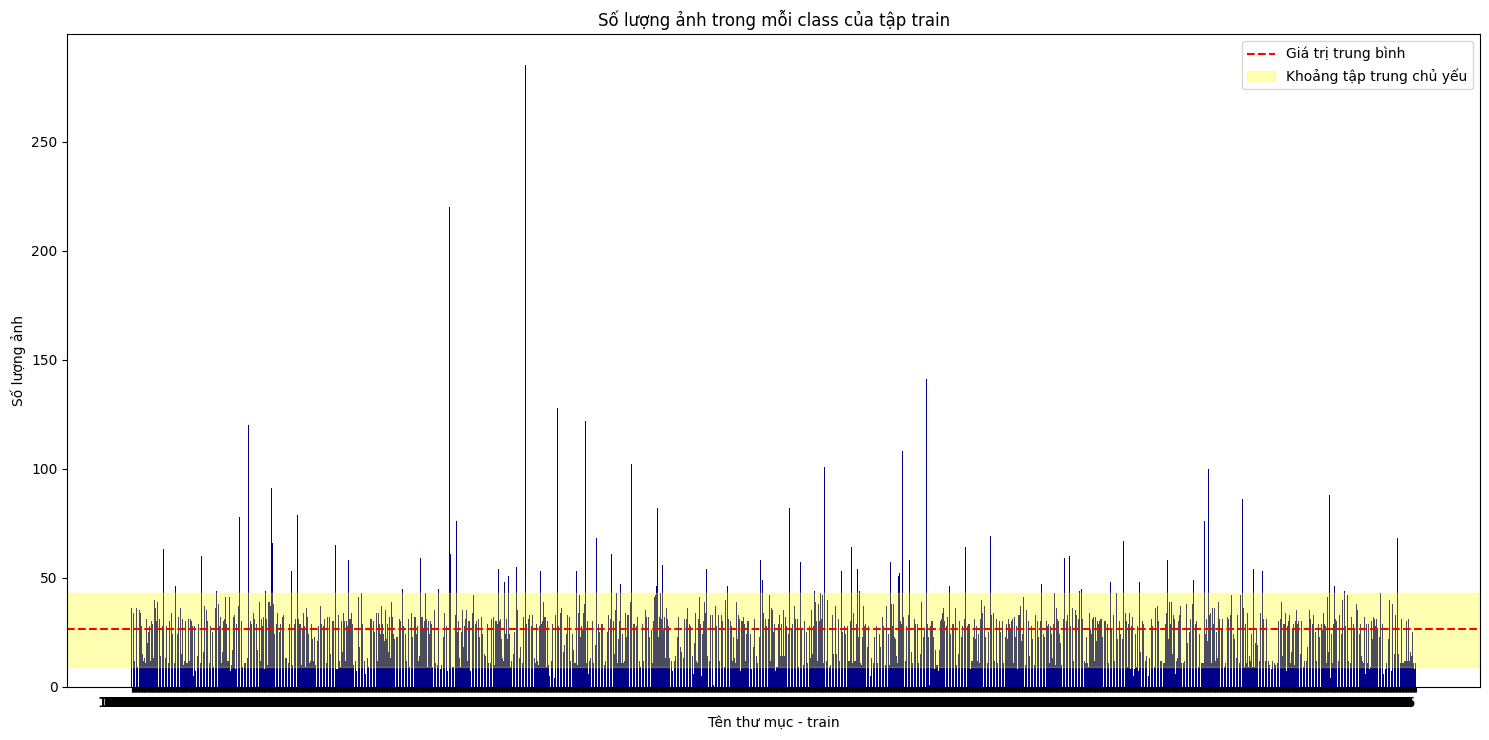

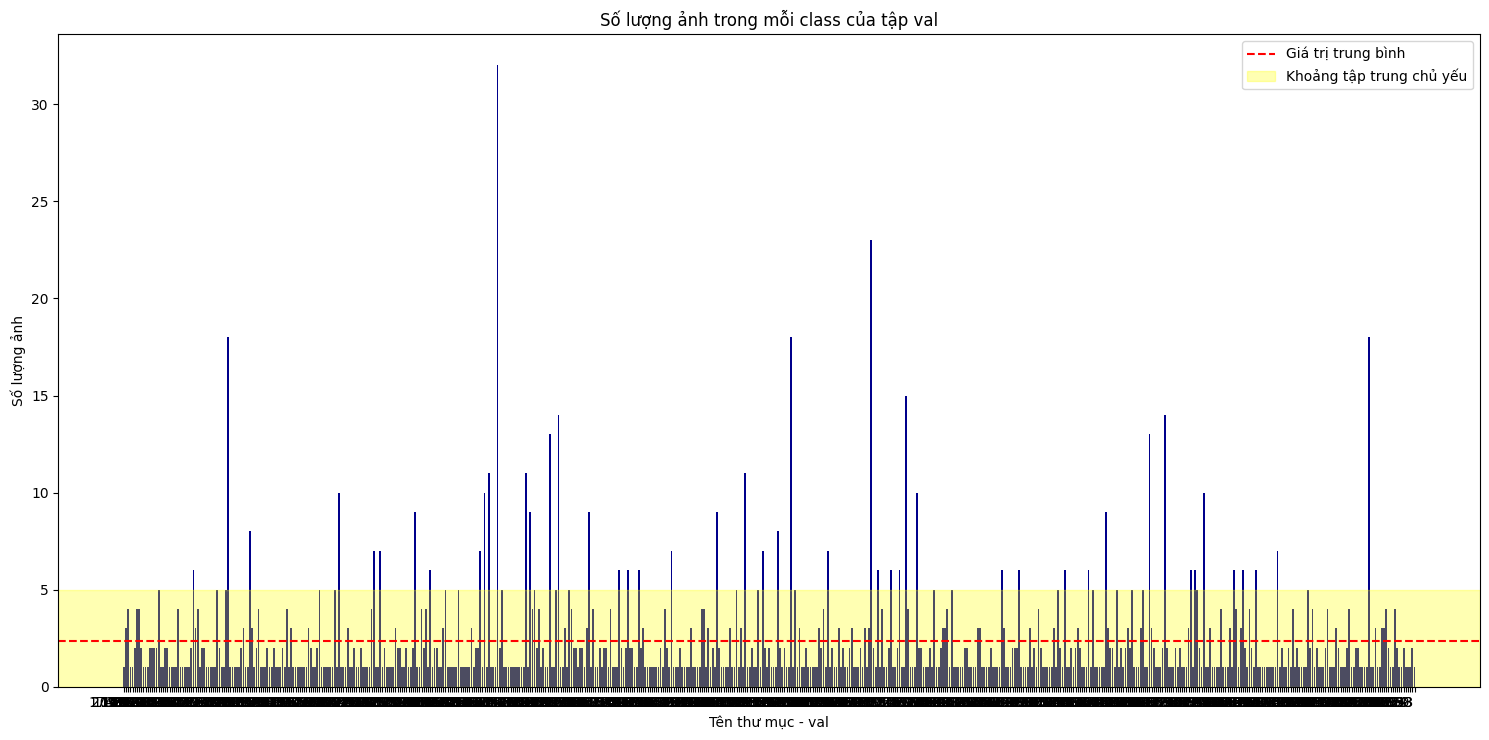

In [32]:
def calculate_image_counts(folder_path):
    image_counts = {}

    for folder_name in os.listdir(folder_path):
        folder_dir = os.path.join(folder_path, folder_name)
        if os.path.isdir(folder_dir):
            num_images = len(os.listdir(folder_dir))
            image_counts[folder_name] = num_images
    return image_counts

train_image_counts = calculate_image_counts(train_folder_path)
val_image_counts = calculate_image_counts(val_folder_path)

train_most_images_folder = max(train_image_counts, key=train_image_counts.get)
train_least_images_folder = min(train_image_counts, key=train_image_counts.get)
train_mean_count = np.mean(list(train_image_counts.values()))
train_std_dev = np.std(list(train_image_counts.values()))
train_lower_bound = int(train_mean_count - train_std_dev)
train_upper_bound = int(train_mean_count + train_std_dev)

print("Tập train:")
print(f"Class có nhiều ảnh nhất: {train_most_images_folder}, số lượng ảnh: {train_image_counts[train_most_images_folder]}")
print(f"Class có ít ảnh nhất: {train_least_images_folder}, số lượng ảnh: {train_image_counts[train_least_images_folder]}")
print(f"Giá trị trung bình: {train_mean_count}")
print(f"Độ lệch chuẩn: {train_std_dev}")
print(f"Data tập trung chủ yếu trong khoảng từ {train_lower_bound} đến {train_upper_bound} ảnh.")

val_most_images_folder = max(val_image_counts, key=val_image_counts.get)
val_least_images_folder = min(val_image_counts, key=val_image_counts.get)
val_mean_count = np.mean(list(val_image_counts.values()))
val_std_dev = np.std(list(val_image_counts.values()))
val_lower_bound = int(val_mean_count - val_std_dev)
val_upper_bound = int(val_mean_count + val_std_dev)

print("\nTập validation:")
print(f"Class có nhiều ảnh nhất: {val_most_images_folder}, số lượng ảnh: {val_image_counts[val_most_images_folder]}")
print(f"Class có ít ảnh nhất: {val_least_images_folder}, số lượng ảnh: {val_image_counts[val_least_images_folder]}")
print(f"Giá trị trung bình: {val_mean_count}")
print(f"Độ lệch chuẩn: {val_std_dev}")
print(f"Data tập trung chủ yếu trong khoảng từ {val_lower_bound} đến {val_upper_bound} ảnh.")

folders_train = list(train_image_counts.keys())
counts_train = list(train_image_counts.values())

plt.figure(figsize=(15, 7.5))
plt.bar(folders_train, counts_train, color='darkblue')
plt.xlabel('Tên thư mục - train')
plt.ylabel('Số lượng ảnh')
plt.title('Số lượng ảnh trong mỗi class của tập train')
plt.xticks(rotation=0, ha='right')
plt.axhline(train_mean_count, color='red', linestyle='--', label='Giá trị trung bình')
plt.axhspan(train_lower_bound, train_upper_bound, color='yellow', alpha=0.3, label='Khoảng tập trung chủ yếu')
plt.legend()
plt.tight_layout()
plt.show()


folders_val = list(val_image_counts.keys())
counts_val = list(val_image_counts.values())

plt.figure(figsize=(15, 7.5))
plt.bar(folders_val, counts_val, color='darkblue')
plt.xlabel('Tên thư mục - val')
plt.ylabel('Số lượng ảnh')
plt.title('Số lượng ảnh trong mỗi class của tập val')
plt.xticks(rotation=0, ha='right')
plt.axhline(val_mean_count, color='red', linestyle='--', label='Giá trị trung bình')
plt.axhspan(val_lower_bound, val_upper_bound, color='yellow', alpha=0.3, label='Khoảng tập trung chủ yếu')
plt.legend()
plt.tight_layout()
plt.show()

# **Tìm tần suất xuất hiện của số lượng ảnh trong từng class**

Số lượng ảnh xuất hiện nhiều nhất trong mỗi class - train: 29
Tần suất xuất hiện của số lượng ảnh này trong tập train: 168


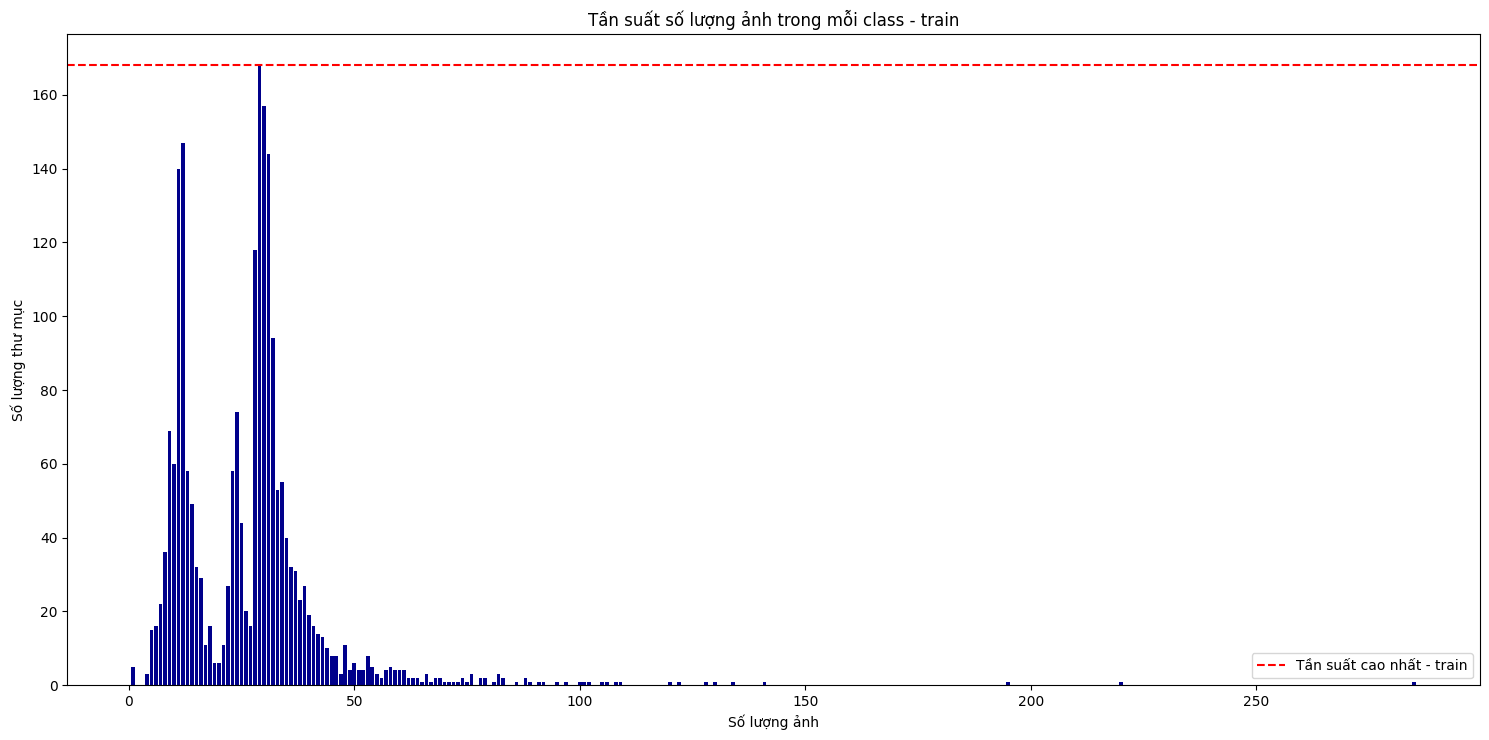

Số lượng ảnh xuất hiện nhiều nhất trong mỗi class - val: 1
Tần suất xuất hiện của số lượng ảnh này trong tập val: 341


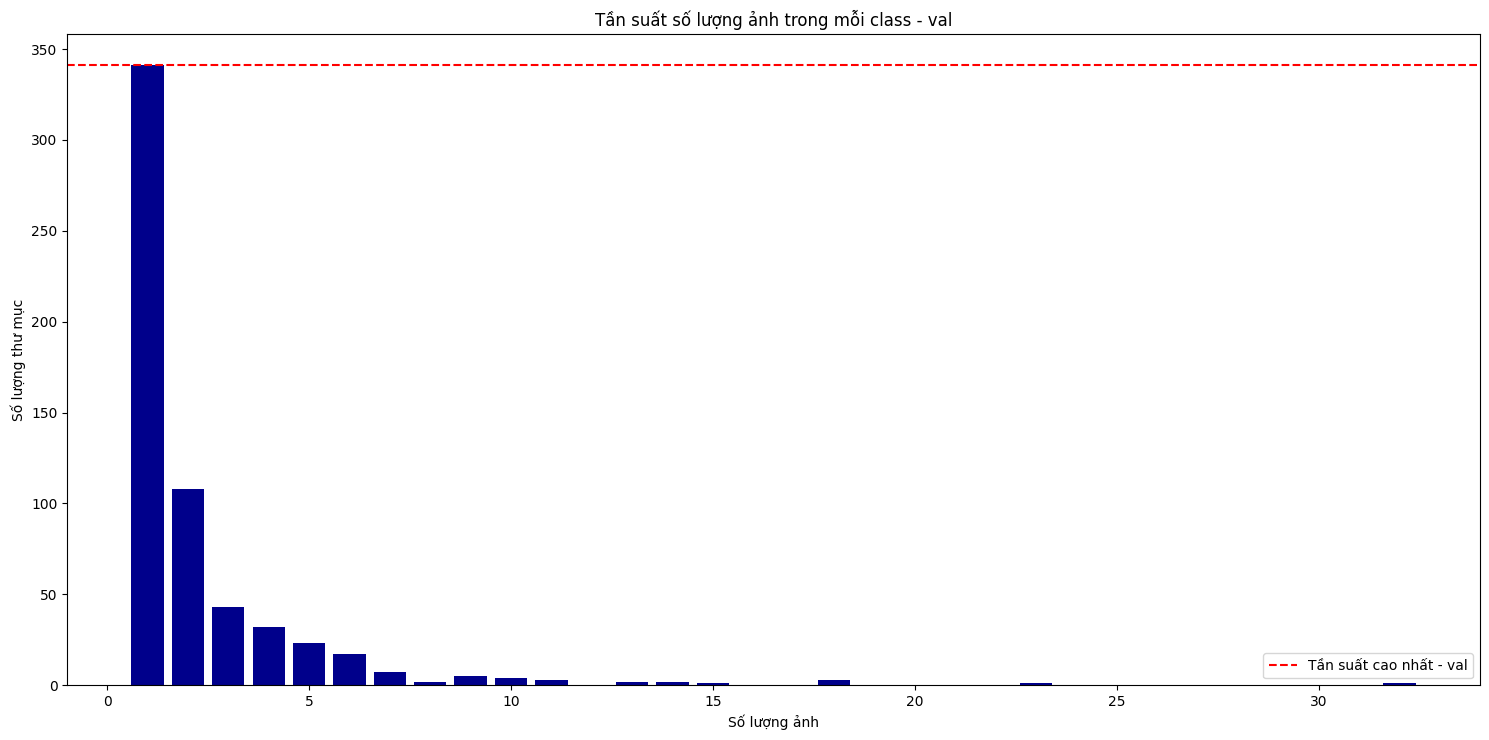

In [34]:
def count_images_in_subfolders(folder_path):
    image_counts = []
 
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            num_images = len(os.listdir(subfolder_path))
            image_counts.append(num_images)

    return image_counts

train_image_counts = count_images_in_subfolders(train_folder_path)
val_image_counts = count_images_in_subfolders(val_folder_path)

train_count_of_counts = Counter(train_image_counts)
val_count_of_counts = Counter(val_image_counts)

train_most_common_count, train_frequency = train_count_of_counts.most_common(1)[0]

print(f"Số lượng ảnh xuất hiện nhiều nhất trong mỗi class - train: {train_most_common_count}")
print(f"Tần suất xuất hiện của số lượng ảnh này trong tập train: {train_frequency}")

plt.figure(figsize=(15, 7.5))
plt.bar(train_count_of_counts.keys(), train_count_of_counts.values(), color='darkblue')
plt.xlabel('Số lượng ảnh')
plt.ylabel('Số lượng thư mục')
plt.title('Tần suất số lượng ảnh trong mỗi class - train')
plt.axhline(train_frequency, color='red', linestyle='--', label='Tần suất cao nhất - train')
plt.legend()
plt.tight_layout()
plt.show()

val_most_common_count, val_frequency = val_count_of_counts.most_common(1)[0]

print(f"Số lượng ảnh xuất hiện nhiều nhất trong mỗi class - val: {val_most_common_count}")
print(f"Tần suất xuất hiện của số lượng ảnh này trong tập val: {val_frequency}")

plt.figure(figsize=(15, 7.5))
plt.bar(val_count_of_counts.keys(), val_count_of_counts.values(), color='darkblue')
plt.xlabel('Số lượng ảnh')
plt.ylabel('Số lượng thư mục')
plt.title('Tần suất số lượng ảnh trong mỗi class - val')
plt.axhline(val_frequency, color='red', linestyle='--', label='Tần suất cao nhất - val')
plt.legend()
plt.tight_layout()
plt.show()


# **Parameters**

In [11]:
# Change batchsize to fit hardware
batch_size = 128

# Training parameters
num_classes = 2139  
learning_rate = 0.001
num_epochs = 50

# Scheduler
step_size = 7
gamma = 0.1

# **Chuẩn bị data**

In [14]:
# Customed Dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = self._find_classes()
        self.image_paths, self.labels = self._load_data()

    def _find_classes(self):
        classes = sorted([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])
        return classes

    def _load_data(self):
        image_paths = []
        labels = []
        for label in self.classes:
            class_dir = os.path.join(self.data_dir, label)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(int(label))
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        label = int(label)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [15]:
input_path = "/kaggle/input/wb-recognition-dataset/wb_recognition_dataset/"
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}
# Datasets from each folder
image_datasets = {
    'train': CustomDataset(train_dir, data_transforms['train']),
    'val': CustomDataset(val_dir, data_transforms['val']),
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory = True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory = True),
}

# Size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [41]:
# Number of images and labels
print('Number of images in train: ', dataset_sizes['train'])
print('Number of labels in train: ',len(image_datasets['train'].classes))
print('Number of images in val: ', dataset_sizes['val'])
print('Number of labels in val: ', len(image_datasets['val'].classes))

Number of images in train:  56813
Number of labels in train:  2130
Number of images in val:  1392
Number of labels in val:  595


# **Test thử data gốc**

Sample images from train_loader:


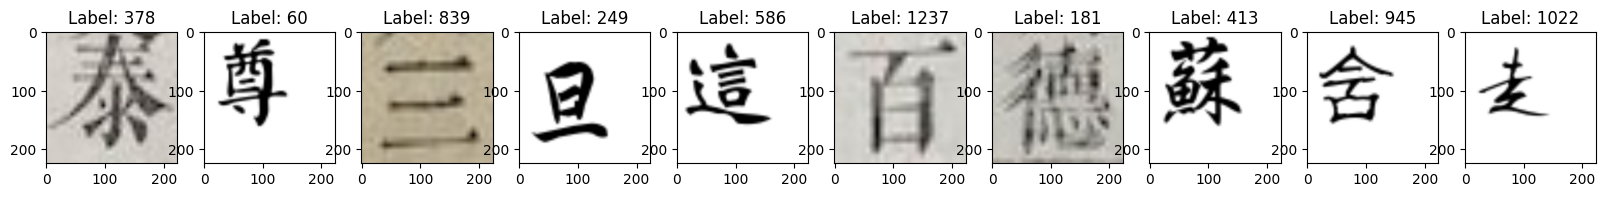

Sample images from val_loader:


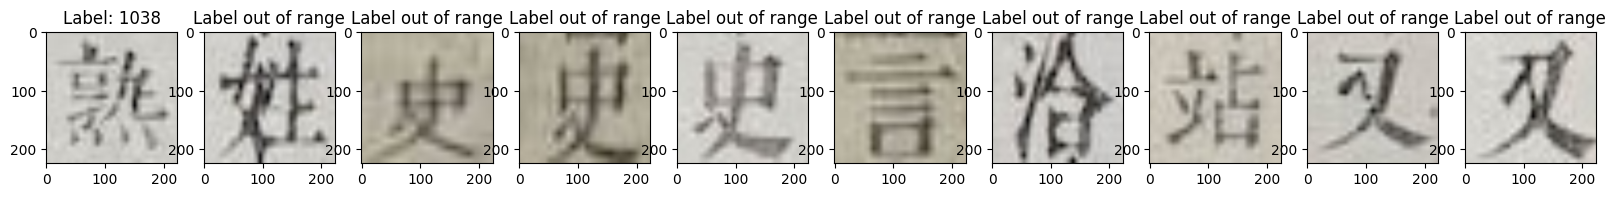

In [16]:
def show_images(dataloader, dataset, num_images=10):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images = images.numpy()

    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

    for i in range(num_images):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        # Check if labels[i] is within the range of available classes
        if labels[i] < len(dataset.classes):
            label_name = dataset.classes[labels[i]]  
            axes[i].set_title(f'Label: {label_name}')
        else:
            axes[i].set_title("Label out of range")

    plt.show()

# Display some images from train_loader
print("Sample images from train_loader:")
show_images(dataloaders['train'], image_datasets['train'])

# Display some images from val_loader
print("Sample images from val_loader:")
show_images(dataloaders['val'], image_datasets['val'])


# **Phân bố chiều dài và chiều rộng ảnh**

In [51]:
def calculate_image_dimensions(dataset_dir):
    width_distribution = {}
    height_distribution = {}

    # Duyệt qua tất cả các thư mục con trong thư mục dữ liệu
    for root, dirs, files in os.walk(dataset_dir):
        # Duyệt qua tất cả các tệp hình ảnh trong thư mục con
        for file in files:
            image_path = os.path.join(root, file)
            try:
                # Mở hình ảnh và lấy kích thước
                with Image.open(image_path) as img:
                    width, height = img.size
                    # Cập nhật phân phối chiều rộng và chiều cao
                    if width in width_distribution:
                        width_distribution[width] += 1
                    else:
                        width_distribution[width] = 1
                    if height in height_distribution:
                        height_distribution[height] += 1
                    else:
                        height_distribution[height] = 1
            except Exception as e:
                print(f"Error processing image: {image_path}, {e}")

    return width_distribution, height_distribution

# Tính toán phân phối chiều rộng và chiều cao 
train_width_dist, train_height_dist = calculate_image_dimensions(train_dir)
val_width_dist, val_height_dist = calculate_image_dimensions(val_dir)

print("Training set width distribution:", train_width_dist)
print("Training set height distribution:", train_height_dist)
print("Validation set width distribution:", val_width_dist)
print("Validation set height distribution:", val_height_dist)

Error processing image: /kaggle/input/wb-recognition-dataset/wb_recognition_dataset/val/labels.csv, cannot identify image file '/kaggle/input/wb-recognition-dataset/wb_recognition_dataset/val/labels.csv'
Training set width distribution: {64: 45532, 31: 931, 27: 606, 28: 658, 32: 1116, 33: 1091, 26: 600, 36: 313, 34: 891, 25: 425, 16: 34, 29: 928, 35: 665, 23: 402, 30: 885, 22: 355, 24: 335, 19: 160, 37: 129, 20: 112, 41: 25, 40: 39, 38: 66, 39: 45, 21: 204, 18: 105, 17: 74, 14: 17, 42: 20, 9: 1, 13: 8, 43: 12, 15: 24, 12: 2, 45: 2, 44: 1}
Training set height distribution: {64: 45532, 22: 703, 28: 657, 26: 1399, 21: 661, 30: 873, 20: 444, 23: 731, 29: 540, 27: 1397, 32: 429, 24: 661, 17: 62, 31: 720, 16: 36, 25: 914, 19: 261, 33: 244, 35: 97, 39: 9, 36: 34, 37: 23, 38: 21, 34: 87, 12: 24, 13: 31, 10: 4, 18: 135, 15: 25, 11: 10, 14: 27, 40: 3, 9: 8, 8: 1, 42: 1, 41: 2, 7: 2, 4: 1, 6: 2, 5: 2}
Validation set width distribution: {35: 110, 27: 83, 31: 128, 36: 58, 34: 154, 33: 164, 32: 146,

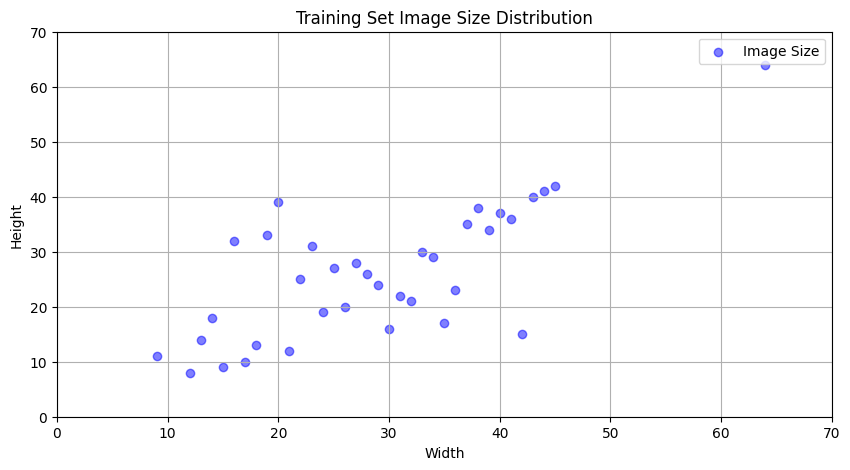

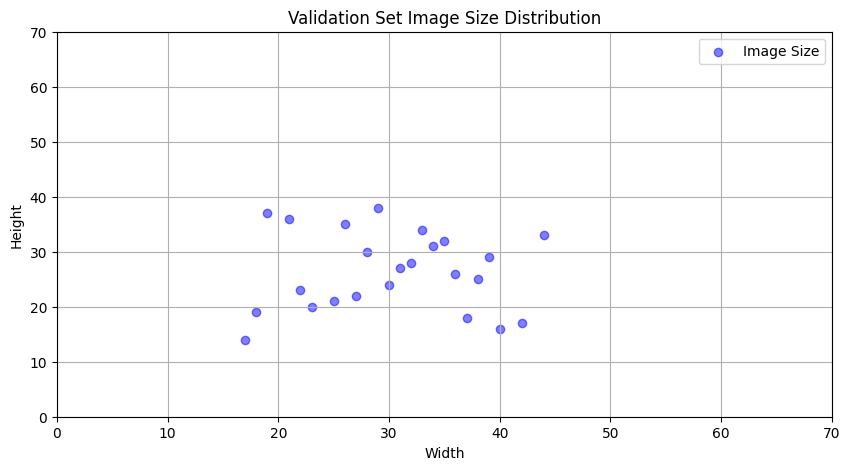

In [52]:
def plot_distribution(width_distribution, height_distribution, dataset_name):
    # Lấy danh sách các cặp chiều rộng và chiều cao
    points = [(w, h) for w, h in zip(width_distribution.keys(), height_distribution.keys())]

    # Tách danh sách chiều rộng và chiều cao
    widths, heights = zip(*points)

    # Vẽ scatter plot
    plt.figure(figsize=(10, 5))
    plt.scatter(widths, heights, color='blue', alpha=0.5, label='Image Size')
    plt.title(f'{dataset_name} Image Size Distribution')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.xlim(0, 70)  
    plt.ylim(0, 70)  
    plt.grid(True)
    plt.legend()
    plt.show()

plot_distribution(train_width_dist, train_height_dist, 'Training Set')
plot_distribution(val_width_dist, val_height_dist, 'Validation Set')

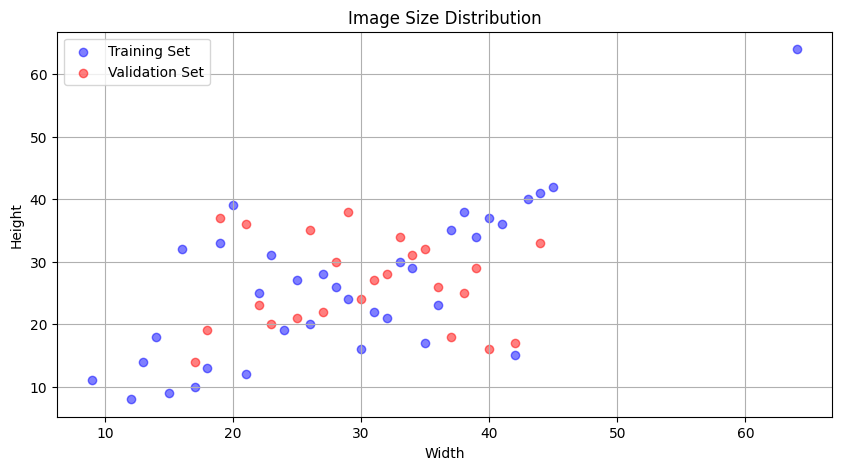

In [53]:
#vẽ cùng 1 biểu đồ

def plot_distribution(train_width_distribution, train_height_distribution, val_width_distribution, val_height_distribution):
    # Lấy danh sách các cặp chiều rộng và chiều cao cho tập huấn luyện
    train_points = [(w, h) for w, h in zip(train_width_distribution.keys(), train_height_distribution.keys())]
    train_widths, train_heights = zip(*train_points)

    # Lấy danh sách các cặp chiều rộng và chiều cao cho tập xác thực
    val_points = [(w, h) for w, h in zip(val_width_distribution.keys(), val_height_distribution.keys())]
    val_widths, val_heights = zip(*val_points)

    # Vẽ scatter plot
    plt.figure(figsize=(10, 5))
    plt.scatter(train_widths, train_heights, color='blue', alpha=0.5, label='Training Set')
    plt.scatter(val_widths, val_heights, color='red', alpha=0.5, label='Validation Set')
    plt.title('Image Size Distribution')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.grid(True)
    plt.legend()
    plt.show()

# Sử dụng hàm để vẽ biểu đồ
plot_distribution(train_width_dist, train_height_dist, val_width_dist, val_height_dist)

# **Phân bố độ sáng**

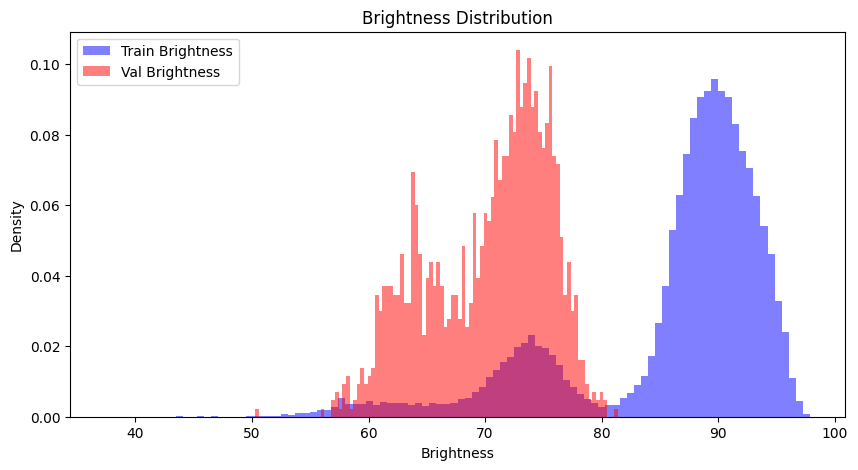

In [54]:
def calculate_brightness_distribution(data_loader):
    brightness_distribution = []

    for images, _ in data_loader:
        for image in images:
            # chuyển đổi hình ảnh sang kgian màu LAB
            lab_image = cv2.cvtColor(image.numpy().transpose(1, 2, 0), cv2.COLOR_RGB2LAB)
            #trích xuất kênh độ sáng (L) từ không gian màu LAB
            brightness = lab_image[:,:,0].mean()  # Giá trị trung bình của kênh L
            brightness_distribution.append(brightness)

    return brightness_distribution

train_brightness_distribution = calculate_brightness_distribution(dataloaders['train'])
val_brightness_distribution = calculate_brightness_distribution(dataloaders['val'])

# biểu đồ ước tính mật độ hạt nhân (KDE) của phân bổ độ sáng
plt.figure(figsize=(10, 5))
plt.hist(train_brightness_distribution, bins=100, color='blue', alpha=0.5, density=True, label='Train Brightness')
plt.hist(val_brightness_distribution, bins=100, color='red', alpha=0.5, density=True, label='Val Brightness')
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Density')
plt.legend()
plt.show()

# **Phân bố RGB**

In [8]:
# chạy hơi lâu
def calculate_rgb_distribution(root_folder):
    distributions = {}

    # Duyệt qua tất cả các thư mục con
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            red_values = []
            green_values = []
            blue_values = []

            # Duyệt qua tất cả các hình ảnh trong thư mục con
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = cv2.imread(image_path)

                # Trích xuất giá trị RGB
                (b, g, r) = cv2.split(image)
                red_values.extend(r.ravel())
                green_values.extend(g.ravel())
                blue_values.extend(b.ravel())

            # Tính toán giá trị trung bình và độ lệch chuẩn
            red_mean, red_std = np.mean(red_values), np.std(red_values)
            green_mean, green_std = np.mean(green_values), np.std(green_values)
            blue_mean, blue_std = np.mean(blue_values), np.std(blue_values)

            distributions[folder_name] = {'red': (red_mean, red_std), 'green': (green_mean, green_std), 'blue': (blue_mean, blue_std)}

    return distributions

train_distribution = calculate_rgb_distribution(train_dir)
val_distribution = calculate_rgb_distribution(val_dir)

#tự bỏ cái này đi đỡ in nhiều
#print('Train RGB Distribution:', train_distribution)
#print('Validation RGB Distribution:', val_distribution)

KeyboardInterrupt: 

# **Test thử data sau khi đã normalize**

In [62]:
def calculate_overall_rgb_distribution(distributions):
    red_values = []
    green_values = []
    blue_values = []

    for folder in distributions.values():
        red_values.append(folder['red'][0])
        green_values.append(folder['green'][0])
        blue_values.append(folder['blue'][0])

    overall_means = [np.mean(red_values), np.mean(green_values), np.mean(blue_values)]
    overall_stds = [np.std(red_values), np.std(green_values), np.std(blue_values)]

    print(overall_means)
    print(overall_stds)
    return overall_means, overall_stds


train_means, train_stds = calculate_overall_rgb_distribution(train_distribution)
val_means, val_stds = calculate_overall_rgb_distribution(val_distribution)


# chuyển giá trị trung bình và độ lệch chuẩn từ phạm vi [0, 255] xuống [0, 1]
train_means = [mean / 255 for mean in train_means]
train_stds = [std / 255 for std in train_stds]
val_means = [mean / 255 for mean in val_means]
val_stds = [std / 255 for std in val_stds]

print('Train Means:', train_means)
print('Train Stds:', train_stds)
print('Validation Means:', val_means)
print('Validation Stds:', val_stds)

[225.49274676869675, 225.3418962275927, 225.02154653554103]
[5.1217948350336036, 5.2452482938161635, 5.526168045861277]
[174.53207168018017, 171.32048556935794, 162.66824249592779]
[11.329959431212282, 12.47031578212409, 15.95528702369112]
Train Means: [0.8842852814458696, 0.883693710696442, 0.8824374373942786]
Train Stds: [0.020085469941308248, 0.02056960115222025, 0.021671247238671674]
Validation Means: [0.6844394967850203, 0.6718450414484625, 0.6379146764546187]
Validation Stds: [0.04443121345573444, 0.048903199145584664, 0.06256975303408283]


In [9]:
# Customed Dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = self._find_classes()
        self.image_paths, self.labels = self._load_data()

    def _find_classes(self):
        classes = sorted([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])
        return classes

    def _load_data(self):
        image_paths = []
        labels = []
        for label in self.classes:
            class_dir = os.path.join(self.data_dir, label)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(int(label))
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        label = int(label)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [12]:
# Chuẩn hóa theo ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
         normalize,
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ]),
}
# Datasets from each folder
image_datasets = {
    'train': CustomDataset(train_dir, data_transforms['train']),
    'val': CustomDataset(val_dir, data_transforms['val']),
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory = True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory = True),
}

# Size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

Sample images from train_loader:


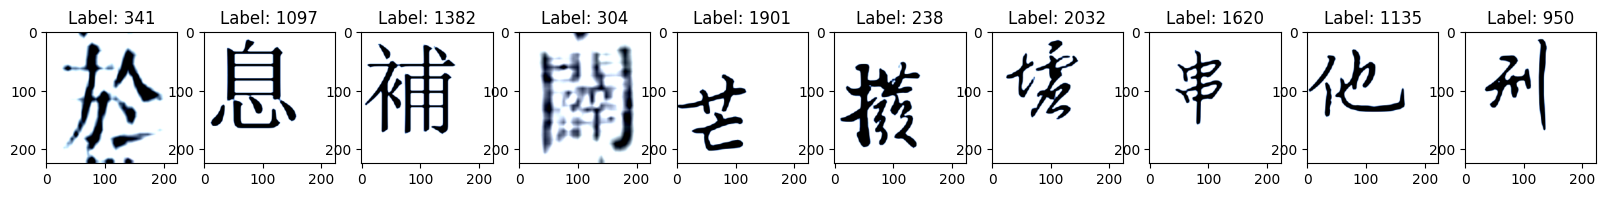

Sample images from val_loader:


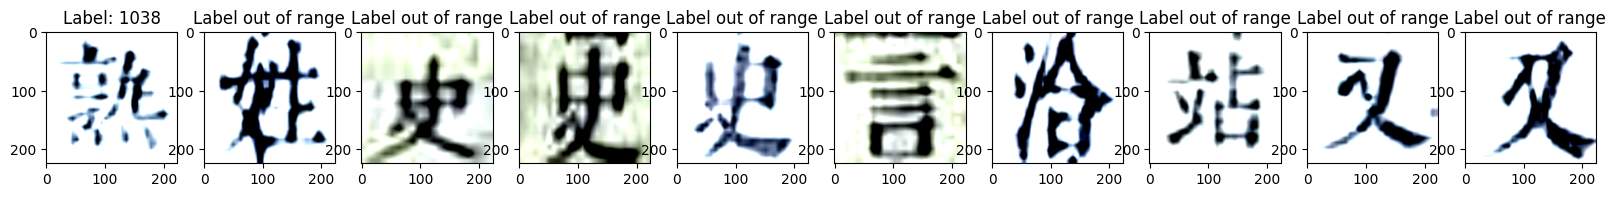

In [34]:
def show_images(dataloader, dataset, num_images=10):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images = images.numpy()

    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

    for i in range(num_images):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        # Check if labels[i] is within the range of available classes
        if labels[i] < len(dataset.classes):
            label_name = dataset.classes[labels[i]]  
            axes[i].set_title(f'Label: {label_name}')
        else:
            axes[i].set_title("Label out of range")

    plt.show()

# Display some images from train_loader
print("Sample images from train_loader:")
show_images(dataloaders['train'], image_datasets['train'])

# Display some images from val_loader
print("Sample images from val_loader:")
show_images(dataloaders['val'], image_datasets['val'])


# **Phân bố độ sáng sau khi đã chuẩn hóa**

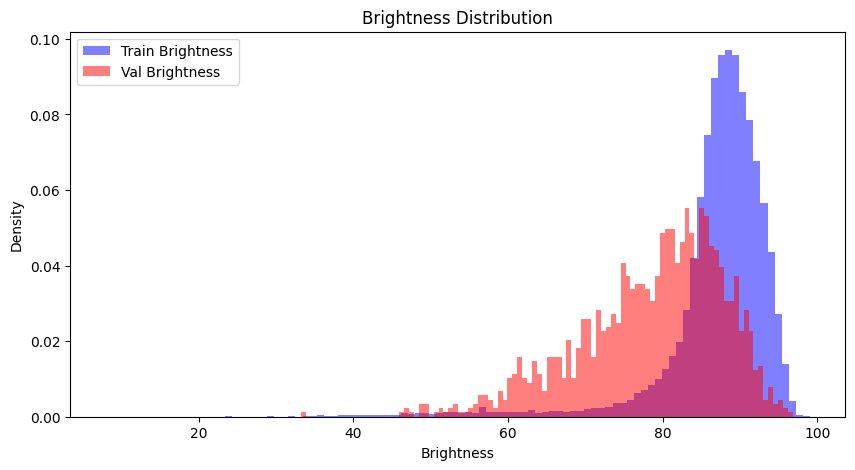

In [13]:
def calculate_brightness_distribution(data_loader):
    brightness_distribution = []

    for images, _ in data_loader:
        for image in images:
            # chuyển đổi hình ảnh sang kgian màu LAB
            lab_image = cv2.cvtColor(image.numpy().transpose(1, 2, 0), cv2.COLOR_RGB2LAB)
            #trích xuất kênh độ sáng (L) từ không gian màu LAB
            brightness = lab_image[:,:,0].mean()  # Giá trị trung bình của kênh L
            brightness_distribution.append(brightness)

    return brightness_distribution

train_brightness_distribution = calculate_brightness_distribution(dataloaders['train'])
val_brightness_distribution = calculate_brightness_distribution(dataloaders['val'])

# biểu đồ ước tính mật độ hạt nhân (KDE) của phân bổ độ sáng
plt.figure(figsize=(10, 5))
plt.hist(train_brightness_distribution, bins=100, color='blue', alpha=0.5, density=True, label='Train Brightness')
plt.hist(val_brightness_distribution, bins=100, color='red', alpha=0.5, density=True, label='Val Brightness')
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Density')
plt.legend()
plt.show()